In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
from torchvision import transforms as T
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import time
from torch.nn import functional as F
from torchvision import models
import torch.nn as nn
import torch
import random
import PIL

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
images = []
label = []
import os
for dirname, _, filenames in os.walk('/content/batikmadura/'):
    #print(dirname)
    for filename in filenames:
        images.append(os.path.join(dirname, filename).split('/')[-1])
        label.append(os.path.join(dirname, filename).split('/')[-2])

In [4]:

labels = np.unique(label)
ints = np.arange(0, len(label))
dicts = dict(zip(labels, ints))
dicts

{'kacangan': 0, 'pancawarna': 1, 'seratbatu': 2, 'seratkayu': 3}

In [5]:
PATH = "/content/batikmadura/"

df_full = pd.DataFrame({'image_id':images, 'label':label})

#FINDING BAD FILE
# "../input/indonesian-batik-motifs/batik-bali/1.jpg"
index = []
for i in range(len(df_full)):
    try:
        Image.open(PATH + str(df_full['label'].values[i]) + '/' + str(df_full['image_id'].values[i]))
    
    except PIL.UnidentifiedImageError:
        index.append(i)

df = df_full.drop(index)
df.head()

,image_id,label
0,82.jpg,kacangan
1,43.jpg,kacangan
2,243.jpg,kacangan
3,166.jpg,kacangan
4,138.jpg,kacangan


In [6]:
# import zipfile  # unziping 
# import glob  # finding image paths
# import numpy as np  # creating numpy arrays
# from skimage.io import imread  # reading images
# from skimage.transform import resize  # resizing images

# # 1. Unzip images
# path = '/content/Kacangan.zip'
# # with zipfile.ZipFile(path, 'r') as zip_ref:
# #     zip_ref.extractall('/content/kacangan_ex')

# # 2. Obtain paths of images (.png used for example)
# img_list = sorted(glob.glob('/content/kacangan_ex/Kacangan/*.jpg'))

# # 3. Read images & convert to numpy arrays
# ## create placeholding numpy arrays
# IMG_SIZE = 256 #(image resolution of 256 x 256 used for example)
# x_data = np.empty((len(img_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

# ## read and convert to arrays
# for i, img_path in enumerate(img_list):
#     # read image
#     img = imread(img_path)
#     # resize image (1 channel used for example; 1 for gray-scale, 3 for RGB-scale)
#     img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
#     # save to numpy array
#     x_data[i] = img

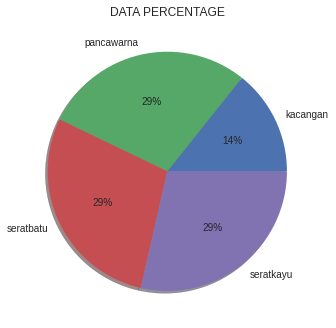

In [7]:
target, count = np.unique(df['label'], return_counts=True)
precentange = [x / np.sum(count) for x in count]
plt.style.use('seaborn')
plt.pie(precentange, labels = target,  autopct='%1.f%%', shadow=True)
plt.title('DATA PERCENTAGE')
plt.show()

In [8]:
class Batik(Dataset):
    def __init__(self, x, y, path, map_label=dicts, transform=None):
        self.X = x
        self.y = y
        self.path = path
        self.map_label = map_label
        self.transform = transform
        
    def __getitem__(self, idx):
        img = Image.open(self.path + str(self.y[idx]) + '/' + str(self.X[idx])).convert('RGB')
        label = self.map_label[self.y[idx]]
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, label

    def __len__(self):
        return len(self.X)
    
X_trainval, X_test, y_trainval, y_test = train_test_split(
    df['image_id'].values, df['label'].values, 
    test_size=0.15, stratify=df['label'].values, 
    random_state=77)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, 
    stratify=y_trainval, test_size=0.15,
    random_state=77)


len(X_train), len(X_val), len(X_test)

(1263, 224, 263)

In [9]:
#DATALOADER
mean= [0.485, 0.456, 0.406] 
std= [0.229, 0.224, 0.225]
batch_size = 24

#data augmentation, dilakukan pada data train dan validatoion
train_transform = T.Compose([T.Resize((128, 128)),
                             T.RandomHorizontalFlip(),
                             T.RandomVerticalFlip(),
                             T.RandomRotation(20),
                             T.ToTensor(),
                             T.Normalize(mean, std)
                            ])

val_transform = T.Compose([T.Resize((128, 128)),
                           T.ToTensor(),
                           T.Normalize(mean, std),
                          ])
#berisi data campuran yang sudah digabungkan dengan data augmentation
train_set = Batik(X_train, y_train, PATH, transform=train_transform)
val_set = Batik(X_val, y_val, PATH, transform=val_transform)
test_set = Batik(X_test, y_val, PATH, transform=val_transform)
#fungsi dalam pytorch untuk mempermudah tranformasi data
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
                                           num_workers=8, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size*2, shuffle=False, 
                                         num_workers=8, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size*2, shuffle=False, 
                                         num_workers=8, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


seratbatu


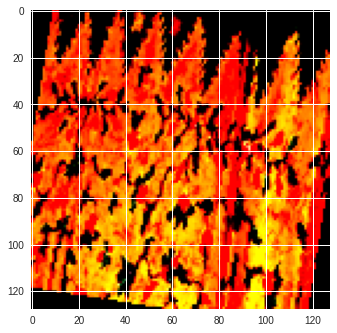

In [10]:
int_label = dict(zip(ints, labels))


img, label = train_set[random.randint(0, len(X_train))]
plt.imshow(img.permute(1,2,0));
print(int_label[label]) 

#  Resnet18

In [11]:
class resnet_block(nn.Module):
    def __init__(self, in_channels, out_channels, 
idt_downsample=None, stride=1):
        super(resnet_block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = idt_downsample
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
            
        x += identity
        x = self.relu(x)
        return x

In [12]:
class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

In [13]:
class ResNet_18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

In [14]:
model = ResNet_18(3, 10)

In [15]:
#count trainable parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

12562698

In [16]:
def accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

epoch = 10
lr = 1e-3 # learning rate
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=epoch,
                                               steps_per_epoch=len(train_loader))

In [17]:
train_losses = []
val_losses =[]
train_accuracy = []
val_acc = []
# The training loss indicates how well the model is fitting the training data, 
# while the validation loss indicates how well the model fits new data.
for e in range(epoch):
    model.to(device)
    model.train()
    
    train_loss = 0
    train_acc = 0
    since = time.time()
    for image, label in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()
        
        image = image.to(device)
        label = label.to(device)
        output = model(image)
        loss = criterion(output, label) #compute a gradient according to a given loss function
        
        train_loss += loss
        train_acc += accuracy(output, label)
        
        loss.backward()#compute gradient tensor
        optimizer.step()#.step buat optimization
        scheduler.step()
        
    else:
        with torch.no_grad():
            model.eval()
            
            running_loss = 0
            val_accuracy =0
            for image, label in val_loader:
                image = image.to(device)
                label = label.to(device)

                output = model(image)
                loss = criterion(output, label)
                val_accuracy += accuracy(output, label)
                running_loss += loss
                
    train_losses.append((train_loss/len(train_loader)).item())
    val_losses.append((running_loss/len(val_loader)).item())
    train_accuracy.append(train_acc/ len(train_loader))
    val_acc.append(val_accuracy/len(val_loader))
    
    print('epochs {}/{}..'.format(e+1, epoch),
          'train loss {:.3f}..'.format(train_loss/len(train_loader)),
          'val loss {:.3f}..'.format(running_loss/len(val_loader)),
          'train accuracy {:.3f}..'.format(train_acc/ len(train_loader)),
          'val accuracy {:.3f}..'.format(val_accuracy/len(val_loader)),
          'time {:.3f} s'.format(time.time() - since)
         )

  0%|          | 0/53 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epochs 1/10.. train loss 1.565.. val loss 1.212.. train accuracy 0.400.. val accuracy 0.415.. time 147.053 s


  0%|          | 0/53 [00:00<?, ?it/s]

epochs 2/10.. train loss 1.181.. val loss 1.813.. train accuracy 0.481.. val accuracy 0.375.. time 134.258 s


  0%|          | 0/53 [00:00<?, ?it/s]

epochs 3/10.. train loss 1.221.. val loss 1.318.. train accuracy 0.454.. val accuracy 0.479.. time 137.927 s


  0%|          | 0/53 [00:00<?, ?it/s]

epochs 4/10.. train loss 1.149.. val loss 1.234.. train accuracy 0.505.. val accuracy 0.479.. time 133.981 s


  0%|          | 0/53 [00:00<?, ?it/s]

epochs 5/10.. train loss 1.063.. val loss 1.589.. train accuracy 0.525.. val accuracy 0.419.. time 134.667 s


  0%|          | 0/53 [00:00<?, ?it/s]

epochs 6/10.. train loss 1.008.. val loss 1.052.. train accuracy 0.564.. val accuracy 0.523.. time 131.896 s


  0%|          | 0/53 [00:00<?, ?it/s]

epochs 7/10.. train loss 0.955.. val loss 1.038.. train accuracy 0.599.. val accuracy 0.562.. time 137.457 s


  0%|          | 0/53 [00:00<?, ?it/s]

epochs 8/10.. train loss 0.878.. val loss 0.904.. train accuracy 0.651.. val accuracy 0.606.. time 141.270 s


  0%|          | 0/53 [00:00<?, ?it/s]

epochs 9/10.. train loss 0.839.. val loss 0.782.. train accuracy 0.644.. val accuracy 0.688.. time 133.378 s


  0%|          | 0/53 [00:00<?, ?it/s]

epochs 10/10.. train loss 0.770.. val loss 0.771.. train accuracy 0.678.. val accuracy 0.671.. time 133.881 s


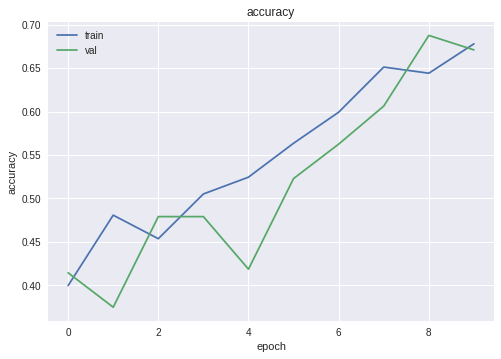

In [18]:
plt.plot(train_accuracy, label='train')
plt.title('accuracy')
plt.ylabel('accuracy'); plt.xlabel('epoch')
plt.plot(val_acc, label='val')
plt.legend()
plt.show()

In [19]:
test_set = Batik(X_test, y_test, PATH, transform=val_transform)
#Context-manager that disabled gradient calculation.
#Disabling gradient calculation is useful for inference, 
#when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations that would otherwise have requires_grad=True.
def predict(model, img, label):
    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)#return gambar yang sudah di transformasi sesuai parameter
        output = model(img)
        pred = torch.argmax(F.softmax(output, dim=1)).cpu().item()
    return pred

test_predict = []
true_label = []
for i in range(len(test_set)):
    img, label = test_set[i]
    prediction = predict(model, img, label)
    test_predict.append(prediction)
    true_label.append(label)

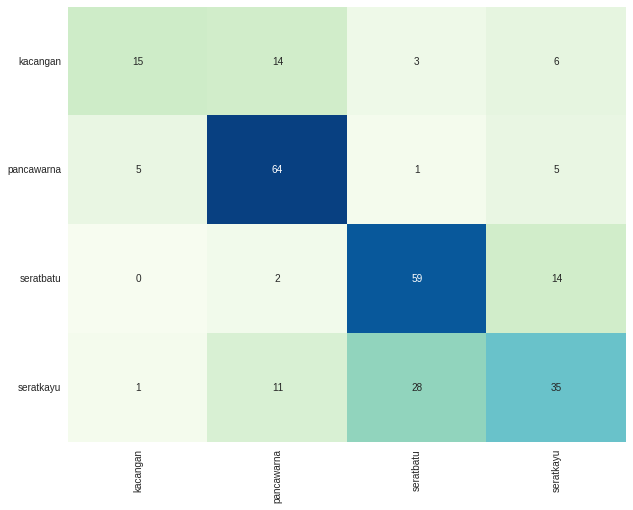

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(true_label, test_predict), annot=True, cmap='GnBu', cbar=False)
plt.xticks(ticks=np.arange(0.5, len(list(dicts.keys()))), labels = list(dicts.keys()), rotation=90)
plt.yticks(ticks=np.arange(0.5, len(list(dicts.keys()))), labels = list(dicts.keys()), rotation=0)
plt.show()

In [21]:
print(classification_report(true_label, test_predict))

              precision    recall  f1-score   support

           0       0.71      0.39      0.51        38
           1       0.70      0.85      0.77        75
           2       0.65      0.79      0.71        75
           3       0.58      0.47      0.52        75

    accuracy                           0.66       263
   macro avg       0.66      0.63      0.63       263
weighted avg       0.66      0.66      0.64       263



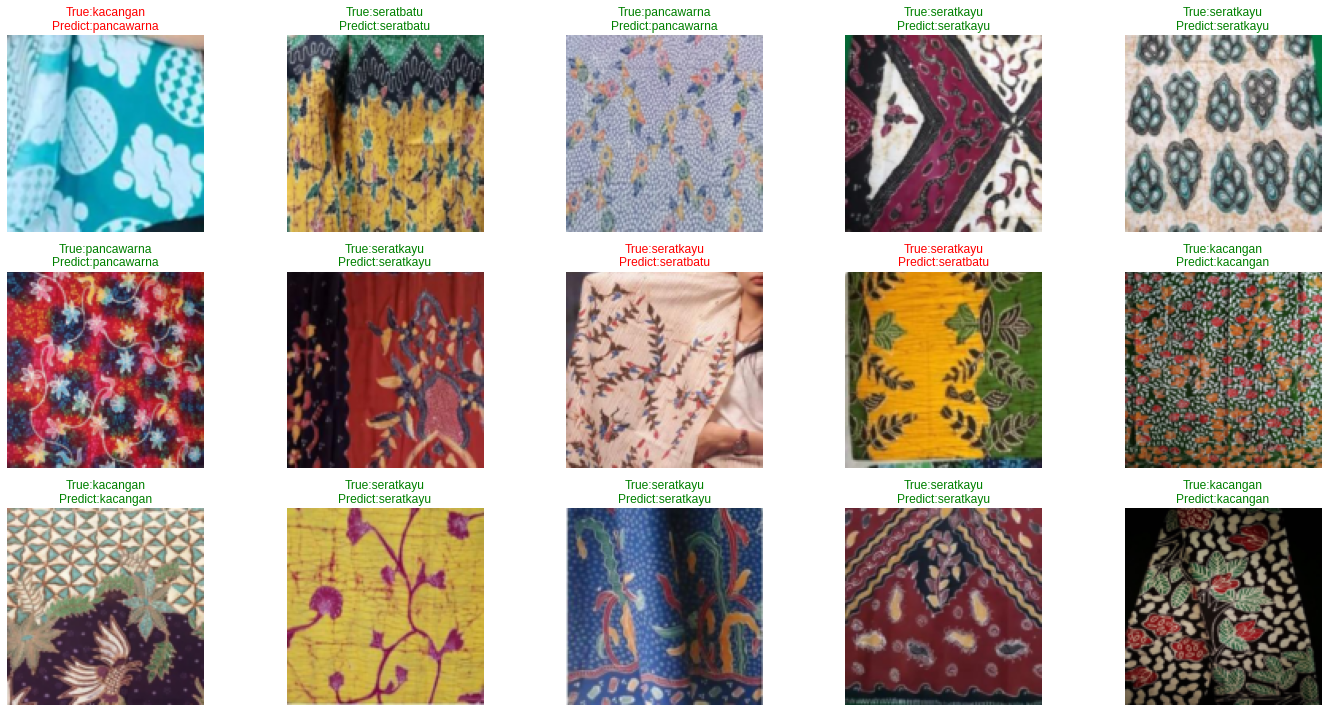

In [22]:
    random_selection = np.random.randint(0, len(test_predict), 15)

    fig = plt.figure(figsize=(20, 10))

    test_set = Batik (X_test, y_test, PATH, transform=T.Resize((124,124)))
    for i, idx in enumerate(random_selection):
        image, label = test_set[idx]
        ax = fig.add_subplot(3, 5, i+1, xticks=[], yticks = [])
        ax.imshow(image)
        ax.set_title('True:{}\nPredict:{}'.format(int_label[label], int_label[test_predict[idx]]),
                    color=("green" if label == test_predict[idx] else 'red'), fontsize=12)

    plt.tight_layout() 
    plt.show()

# Multi Player Perceptron

In [37]:
import torch.nn as nn
import torch.nn.functional as F
# define NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(49152,120)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(120,240)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(240,10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        # flatten image input
        x = x.view(x.size(0),-1)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.droput(x)
         # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.droput(x)
        # add output layer
        x = self.fc3(x)
        return x
# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=49152, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=240, bias=True)
  (fc3): Linear(in_features=240, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


In [24]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

In [38]:
# number of epochs to train the model
n_epochs = 10
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity
for epoch in range(n_epochs):
    # monitor losses
    train_loss = 0
    valid_loss = 0
    
     
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data,label in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
        
     ######################    
    # validate the model #
    ######################
    model.eval()  # prep model for evaluation
    for data,label in val_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss = loss.item() * data.size(0)
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(val_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1 	Training Loss: 2.319696 	Validation Loss: 0.328349
Validation loss decreased (inf --> 0.328349).  Saving model ...
Epoch: 2 	Training Loss: 2.313845 	Validation Loss: 0.328349
Validation loss decreased (0.328349 --> 0.328349).  Saving model ...
Epoch: 3 	Training Loss: 2.310896 	Validation Loss: 0.328349
Validation loss decreased (0.328349 --> 0.328349).  Saving model ...
Epoch: 4 	Training Loss: 2.313262 	Validation Loss: 0.328349
Validation loss decreased (0.328349 --> 0.328349).  Saving model ...
Epoch: 5 	Training Loss: 2.315920 	Validation Loss: 0.328349
Validation loss decreased (0.328349 --> 0.328349).  Saving model ...
Epoch: 6 	Training Loss: 2.318899 	Validation Loss: 0.328349
Validation loss decreased (0.328349 --> 0.328349).  Saving model ...
Epoch: 7 	Training Loss: 2.317335 	Validation Loss: 0.328349
Validation loss decreased (0.328349 --> 0.328349).  Saving model ...
Epoch: 8 	Training Loss: 2.314711 	Validation Loss: 0.328349
Validation loss decreased (0.32834

In [26]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
acc = list(0. for i in range(10))
model.eval() # prep model for evaluation
for data, target in train_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        #print(i)
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        #print(class_correct[label])
# calculate and print avg test loss
test_loss = test_loss/len(train_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for j in range(10):
    if class_total[j] >0:
        #print(class_total[i])
        acc[j] = 100 * class_correct[j] / class_total[j]
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[j] / class_total[j],
            np.sum(class_correct[j]), np.sum(class_total[j])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' )
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Loss: 1.167174

Test Accuracy of    14:  1% ( 3/180)
Test Accuracy of    14: 13% (49/361)
Test Accuracy of    14: 59% (214/361)
Test Accuracy of    14: 80% (291/361)
Test Accuracy of %5s: N/A (no training examples)
Test Accuracy of %5s: N/A (no training examples)
Test Accuracy of %5s: N/A (no training examples)
Test Accuracy of %5s: N/A (no training examples)
Test Accuracy of %5s: N/A (no training examples)
Test Accuracy of %5s: N/A (no training examples)

Test Accuracy (Overall): 44% (557/1263)


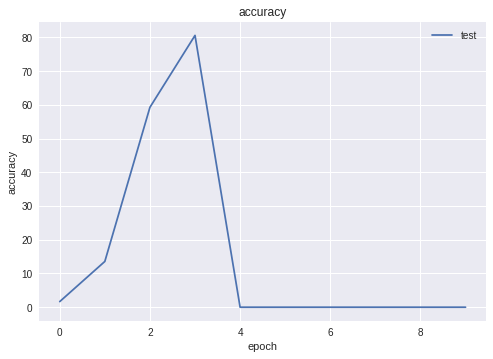

In [27]:
plt.plot(acc, label='test')
plt.title('accuracy')
plt.ylabel('accuracy'); plt.xlabel('epoch')
plt.legend()
plt.show()

In [28]:
print()

In [35]:
test_set = Batik(X_test, y_test, PATH, transform=val_transform)
#Context-manager that disabled gradient calculation.
#Disabling gradient calculation is useful for inference, 
#when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations that would otherwise have requires_grad=True.
def predict(model, img, label):
    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)#return gambar yang sudah di transformasi sesuai parameter
        output = model(img)
        pred = torch.argmax(F.softmax(output, dim=1)).cpu().item()
    return pred

test_predict = []
true_label = []
for i in range(len(test_set)):
    img, label = test_set[i]
    prediction = predict(model, img, label)
    test_predict.append(prediction)
    true_label.append(label)

In [30]:
print(len(class_correct))

10


KeyError: ignored

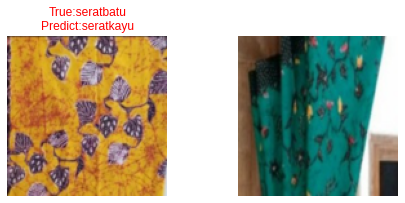

In [36]:
random_selection = np.random.randint(0, len(class_correct), 15)

fig = plt.figure(figsize=(20, 10))

test_set = Batik (X_test, y_test, PATH, transform=T.Resize((124,124)))
for i, idx in enumerate(random_selection):
  image, label = test_set[i]
  ax = fig.add_subplot(3, 5, i+1, xticks=[], yticks = [])
  ax.imshow(image)
  ax.set_title('True:{}\nPredict:{}'.format(int_label[label], int_label[class_correct[i]]),
                    color=("green" if label == class_correct[i] else 'red'), fontsize=12)

plt.tight_layout() 
plt.show()  

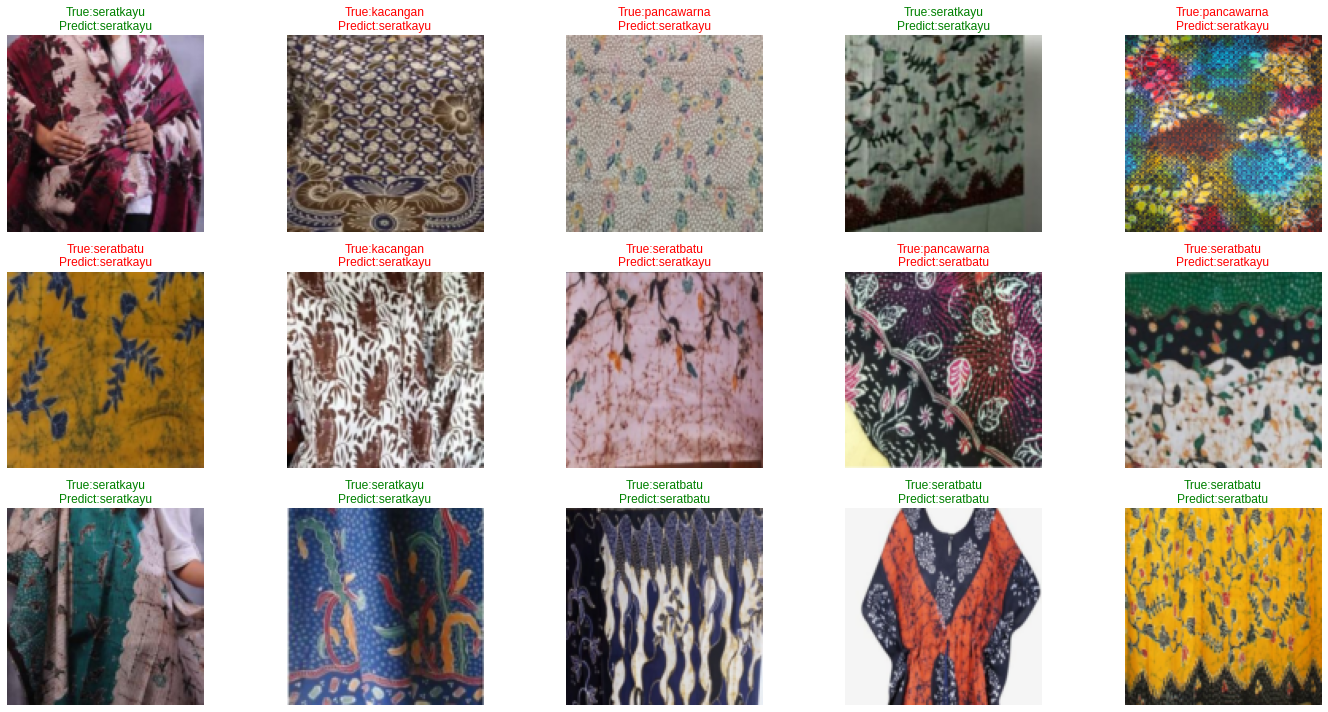

In [32]:
    random_selection = np.random.randint(0, len(test_predict), 15)

    fig = plt.figure(figsize=(20, 10))

    test_set = Batik (X_test, y_test, PATH, transform=T.Resize((124,124)))
    for i, idx in enumerate(random_selection):
        image, label = test_set[idx]
        ax = fig.add_subplot(3, 5, i+1, xticks=[], yticks = [])
        ax.imshow(image)
        ax.set_title('True:{}\nPredict:{}'.format(int_label[label], int_label[test_predict[idx]]),
                    color=("green" if label == test_predict[idx] else 'red'), fontsize=12)

    plt.tight_layout() 
    plt.show()